In [1]:
from Tools import *
from photoObject import *
from MCMCObject import *
import emcee
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from Tools import *
from joblib import Parallel, delayed

8.436941055549651e-18 7.7e-18 1.0957066305908638
4.484106248252349e-18 3.5e-18 1.2811732137863856
2.8494385672828423e-18 2.3e-18 1.2388863336012357
nan nan nan
6.0706628448576554e-18 4.5e-18 1.3490361877461456
1.2689119199219896e-17 1.3e-17 0.9760860922476843
1.6637783011693174e-17 1.4e-17 1.1884130722637982
1.6025052651310306e-18 1.7e-18 0.9426501559594297
2.917264383179723e-18 2.3e-18 1.2683758187737926
4.7608829431775e-18 3.3e-18 1.4426918009628786
3.826520630949098e-18 nan nan


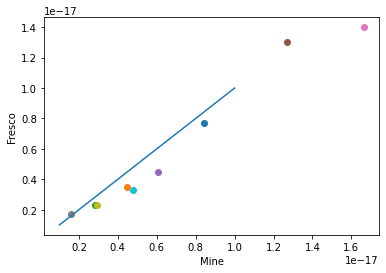

In [18]:
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")



flux_dict = {
    "z6_GNW_14511": {"id": 30244, "flux": 7.7e-18},
    "z6_GND_36100": {"id": 29525, "flux": 3.5e-18},
    "z6_GND_43125": {"id": 2432, "flux": 2.3e-18},
    "z7_GND_8358": {"id": 4650, "flux": np.nan},
    "z5_GND_39445": {"id": 31564, "flux": 4.5e-18},
    "z5_GND_27819": {"id": 23493, "flux": 1.3e-17},
    "z5_GND_21153": {"id": 17353, "flux": 1.4e-17},
    "z5_GND_17752": {"id": 13902, "flux": 1.7e-18},
    "Stark11_33_17705": {"id": 21531, "flux": 2.3e-18},
    "Stark11_34_24923": {"id": 4427, "flux": 3.3e-18},
    "Jung18_z6_GND_28438": {"id": 24032, "flux": np.nan}
}


for gal in Catalog:
    try:
        print(10**gal["HaFlux"],flux_dict[gal["id_charlotte"]]["flux"],10**gal["HaFlux"]/flux_dict[gal["id_charlotte"]]["flux"])
        plt.scatter(10**gal["HaFlux"],flux_dict[gal["id_charlotte"]]["flux"])
    except:
        x=0

plt.plot([1e-18,1e-17],[1e-18,1e-17])
plt.xlabel("Mine")
plt.ylabel("Fresco")
plt.show()

In [ ]:
Lya/Ha

## Fix Fluxes and EW

In [3]:
Fluxes=ascii.read('../A-Catalogs/BLAS_data26Feb.cat') 
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
Backup=ascii.read("../A-Catalogs/Binospec-Candels-noSlitLoss.cat")
props=np.load("../A-Catalogs/ForMaster/OtherProperties.npy",allow_pickle=True)

run=False
if run==True:
    Catalog["Slit_loss?"]=[0 for gal in Catalog]
    for f in Fluxes:
        for gal in Catalog:
            if gal["id_charlotte"]==f["ID"] and f["LyaFlux"]<-10:
                plt.scatter(f["LyaFlux"],gal["LyaFlux"])
                gal["LyaFlux"]=f["LyaFlux"]
                gal["LyaErr"]=f["LyaErr"]


    plt.plot([-18,-16],[-18,-16])
    plt.show()
    #ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  



if run==True:
    Catalog["Slit_loss?"]=[0 for gal in Catalog]
    for p in props:
        for gal in Catalog:
            if gal["id_charlotte"]==p["ID"]:
                plt.scatter(p["EWLya"],gal["EWLya"])
                gal["EWLya"]=p["EWLya"]
                gal["dEWLya"]=p["dEWLya"]


    plt.xlim(0,300)
    plt.ylim(0,300)
    plt.show()

    #ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  

 ####Useless cuz I have mcmc

if run==True:
    Catalog["Slit_loss?"]=[0 for gal in Catalog]
    for p in Backup:
        for gal in Catalog:
            if gal["id_charlotte"]==p["id_charlotte"]:
                plt.scatter(p["FluxLim"],gal["FluxLim"])
                gal["FluxLim"]=p["FluxLim"]
                #gal["dEWLya"]=p["dEWLya"]
    #plt.xlim(0,300)
    #plt.ylim(0,300)
    plt.show()
    #ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  



In [2]:
def SMC_line_dustCurve(wave):  #Reddy2020, only works below Halpha wanvelength , wave in micron
    return -0.816 + 2.286/wave

def SMC_quad_dustCurve(wave):  #Reddy2020, only works below Halpha wanvelength
    return 3.719-2.519/wave + 1.196/wave**2

def SMC_colorDecr(slope):
    return (slope+2.616)*(1/11.259)

def Reddy_unatennuation(slope): #This has to be multiplied to the observed flux
    k_ha=np.mean([SMC_line_dustCurve(0.6568),SMC_quad_dustCurve(0.6568)])
    E_BV=SMC_colorDecr(slope)
    A_ha=k_ha*E_BV
    att=10**(-0.4*A_ha)
    if att>1:
        return 1
    else:
        return att

def Lam_unattenuation(slope):
    if slope<-2.23:
        return 1
    else:
        return (10**(1.1*(slope+2.23)/-2.5))**(2.6/13.2)


k($\lambda$) Linear:  2.6645115712545677 Quadratic:  2.6561955860251816
0.8745384764739301 0.9551391940532299


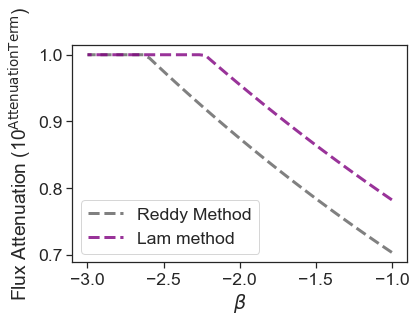

In [3]:
print(r"k($\lambda$) Linear: ",SMC_line_dustCurve(0.6568),"Quadratic: ",SMC_quad_dustCurve(0.6568))
print(Reddy_unatennuation(-2),Lam_unattenuation(-2))

slp=np.linspace(-1,-3)

sns.set_theme(style="ticks",font_scale=1.6)

plt.plot(slp,[Reddy_unatennuation(s) for s in slp],ls="--",color="gray",lw=3,label="Reddy Method")
plt.plot(slp,[Lam_unattenuation(s) for s in slp],ls="--",color="purple",lw=3,alpha=0.8,label="Lam method")
plt.legend()
plt.xlabel(r"$\beta$")
plt.ylabel(r"Flux Attenuation (10$^{\mathrm{Attenuation Term}}$)")
plt.show()


### Apply Slit Loss to Catalog
- Be careful to not run this twice I will leave a failsafe column that indicates that slit loss is applied



In [9]:
return_to_normal=False

if return_to_normal==True:
    betaCAt=ascii.read("../A-Catalogs/Binospec-Candels-noSlitLoss.cat")
    betaCat_dict = {row["id_charlotte"]: [row["EWLya"],row["LyaFlux"],row["FluxLim"]] for row in betaCAt}
    for gal in Catalog:
        gal["EWLya"]=betaCat_dict[gal["id_charlotte"]][0]
        gal["LyaFlux"]=betaCat_dict[gal["id_charlotte"]][1]
        gal["FluxLim"]=betaCat_dict[gal["id_charlotte"]][2]
        gal["Slit_loss?"]=0

In [10]:
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
SlitLoss=np.load("../A-Catalogs/slit_losses.npy",allow_pickle=True).tolist()
for gal in Catalog:
    if gal["Slit_loss?"]==0 and gal["Type"]=="LAE":
        print(10**gal["LyaFlux"])
        print(10**gal["LyaFlux"]/SlitLoss[gal["id_charlotte"]])
        #print(gal["EWLya"])
        #print(gal["EWLya"]/SlitLoss[gal["id_charlotte"]])

        gal["LyaFlux"]=np.log10(10**gal["LyaFlux"]/SlitLoss[gal["id_charlotte"]])
        gal["EWLya"]=gal["EWLya"]/SlitLoss[gal["id_charlotte"]]
        gal["Slit_loss?"]=1

    if gal["Slit_loss?"]==0 and gal["Type"]=="NonDetect":
        print(10**gal["FluxLim"])
        print(10**gal["FluxLim"]/0.67)
        print(gal["EWLya"])
        print(gal["EWLya"]/0.67)

        gal["FluxLim"]=np.log10(10**gal["FluxLim"]/0.67)
        gal["EWLya"]=gal["EWLya"]/0.67
        gal["Slit_loss?"]=1
ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  




## This script is for getting fesc, but first you have to run Get LAE and GET nonLAE

Some LAE inFresco have no Haflux because the line was outisde the wavelength range.

In [15]:
run=True

if run ==True:
    LyaHa=np.load("../A-Catalogs/ForMaster/LyaHa.npy",allow_pickle=True)
    noLyaHa=np.load("../A-Catalogs/ForMaster/noLyaHa.npy",allow_pickle=True)
    inFoV_limits=np.load("../A-Catalogs/ForMaster/inFoV_Limits.npy",allow_pickle=True)
    Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
   #SlitLoss=np.load("../A-Catalogs/slit_losses.npy",allow_pickle=True)

    def Get_fesc_LyaHa(data,cat):
        ha,dha=data["HaFlux"][0],data["HaFlux"][1]
        lya=10**[gal["LyaFlux"] for gal in cat if data["ID"]==gal["id_charlotte"]][0]
        dlya=10**[gal["LyaErr"] for gal in cat if data["ID"]==gal["id_charlotte"]][0]
        slope=[gal["slope"] for gal in cat if data["ID"]==gal["id_charlotte"]][0]
        dslope=[gal["dslope"] for gal in cat if data["ID"]==gal["id_charlotte"]][0]
        fesc=lya/(8.7*ha)
        dfesc=(fesc)*(np.sqrt(  (dha/ha)*2  + (dlya/lya)**2  ))
        
        random_slopes=np.random.normal(loc=slope,scale=dslope,size=1000)

        if dfesc>0:# Case where Ha is measured
            random_attenuations=np.array([Lam_unattenuation(slp) for slp in random_slopes])
            random_fesc=np.random.normal(loc=fesc,scale=dfesc,size=1000)
            random_fesc_unattenuated=random_fesc*random_attenuations
            return [np.median(random_fesc_unattenuated),np.std(random_fesc_unattenuated)]
            #print(gal["ID"],fesc,[np.median(random_fesc_unattenuated),np.std(random_fesc_unattenuated)])

        if np.isnan(dfesc)==True: #Case where Ha is upperlimit
            random_attenuations=np.array([Lam_unattenuation(slp) for slp in random_slopes])
            random_fesc_unattenuated=fesc*random_attenuations
            return [np.median(random_fesc_unattenuated),np.nan]

    def Get_fesc_noLyaHa(data,cat):
        ha,dha=data["HaFlux"][0],data["HaFlux"][1]
        print(data)
        lya=10**[gal["FluxLim"] for gal in cat if data["ID"]==gal["id_charlotte"]][0]
        slope=[gal["slope"] for gal in cat if data["ID"]==gal["id_charlotte"]][0]
        fesc=lya/(8.7*ha)
        fesc_unattenuated=fesc*Lam_unattenuation(slope)
        
        return [fesc_unattenuated,np.nan]



    def Get_fesc_onlyFov(data,cat):
        ha,dha=data["HaFlux"][0],data["HaFlux"][1]
        id=list(cat["id_charlotte"]).index(data["ID"])
        gal=cat[id]
        lya=10**gal["LyaFlux"]
        if np.isnan(lya)==True:
            return [np.nan,np.nan]

            
        slope=[gal["slope"] for gal in cat if data["ID"]==gal["id_charlotte"]][0]


        fesc=lya/(8.7*ha)
        
        fesc_unattenuated=fesc*Lam_unattenuation(slope)
        
        return [fesc_unattenuated,np.nan]


    for gal in inFoV_limits:
        gal["fesc"]=Get_fesc_onlyFov(gal,Catalog)


    for gal in LyaHa:
        gal["fesc"]=Get_fesc_LyaHa(gal,Catalog)

    for gal in noLyaHa:
        gal["fesc"]=Get_fesc_noLyaHa(gal,Catalog)


    # Add fesc,voff,EWHa,Hafwhm
    EmptyArray=[np.nan for gal in Catalog]

    Catalog["HaFlux"]=EmptyArray
    Catalog["dHaFlux"]=EmptyArray
    Catalog["EWHa"]=EmptyArray
    Catalog["dEWHa"]=EmptyArray
    Catalog["HaFWHM"]=EmptyArray
    Catalog["dHaFWHM"]=EmptyArray
    Catalog["fesc"]=EmptyArray
    Catalog["dfesc"]=EmptyArray
    Catalog["voff"]=EmptyArray
    Catalog["dvoff"]=EmptyArray
    Catalog["zsys"]=EmptyArray
    Catalog["line"]=["    " for gal in Catalog]



    def FillCat_LyaHa(Cat,arr):
        for galA in arr:

            for galC in Cat:
                
                if galC["id_charlotte"]==galA["ID"]:
                    
                    galC["HaFlux"]=np.log10(galA["HaFlux"])[0]
                    galC["dHaFlux"]=np.log10(galA["HaFlux"])[1]

                    print(galA)
                    UnattenuatedHa=galA["EWHa"][0] /Lam_unattenuation(galC["slope"])       
                    dUnattenuatedHa=  galA["EWHa"][1]/Lam_unattenuation(galC["slope"])       



                
                    galC["EWHa"]=UnattenuatedHa
                    galC["dEWHa"]=dUnattenuatedHa
                    galC["HaFWHM"]=galA["HaFWHM"][0]
                    galC["dHaFWHM"]=galA["HaFWHM"][1]
                    galC["fesc"]=galA["fesc"][0]
                    galC["dfesc"]=galA["fesc"][1]
                    galC["voff"]=galA["Off"][0]
                    galC["dvoff"]=np.abs(galA["Off"][1])
                    galC["zsys"]=galA["zsys"][1]  
                    galC["line"]=galA["line"]

    def FillCat_noLyaHa(Cat,arr):
       # a=[]
        for galA in arr:

            for galC in Cat:
                if galC["id_charlotte"]==galA["ID"]:
                    
                    galC["HaFlux"]=np.log10(galA["HaFlux"])[0]
                    galC["dHaFlux"]=np.log10(galA["HaFlux"])[1]

                    UnattenuatedHa=galA["EWHa"][0]
                    dUnattenuatedHa=galA["EWHa"][1]

                    UnattenuatedHa=galA["EWHa"][0]  /Lam_unattenuation(galC["slope"])     
                    dUnattenuatedHa=  galA["EWHa"][1]  /Lam_unattenuation(galC["slope"])     

                        
                    galC["EWHa"]=UnattenuatedHa
                    galC["dEWHa"]=dUnattenuatedHa
                    galC["HaFWHM"]=galA["HaFWHM"][0]
                    galC["dHaFWHM"]=galA["HaFWHM"][1]
                    galC["fesc"]=galA["fesc"][0]
                    #galC["dfesc"]=galA["fesc"][1]
                    #galC["voff"]=galA["HaOff"][0]
                    #galC["dvoff"]=np.abs(galA["HaOff"][1])
                    galC["zsys"]=galA["zsys"][1]  
                    galC["line"]=galA["line"]

    def FillCat_OnlyFoV(Cat,arr):
        for galA in arr:

            for galC in Cat:
                if galC["id_charlotte"]==galA["ID"]:
                    
                    galC["HaFlux"]=np.log10(galA["HaFlux"])[0]
                    galC["dHaFlux"]=np.log10(galA["HaFlux"])[1]

                    
                    UnattenuatedHa=galA["EWHa"][0]
                    dUnattenuatedHa=galA["EWHa"][1]

                    UnattenuatedHa=galA["EWHa"][0]  /Lam_unattenuation(galC["slope"])     
                    dUnattenuatedHa=  galA["EWHa"][1]  /Lam_unattenuation(galC["slope"])     

                        
                    galC["EWHa"]=UnattenuatedHa
                    galC["dEWHa"]=dUnattenuatedHa

                    galC["fesc"]=galA["fesc"][0]



    FillCat_LyaHa(Catalog,LyaHa)
    FillCat_noLyaHa(Catalog,noLyaHa)
    FillCat_OnlyFoV(Catalog,inFoV_limits)


    def addInFresco(Catalog,LAE,noLAE):
        EmptyArray=["XXFresco" for gal in Catalog]
        Catalog["inFresco"]=EmptyArray
        inFresco=list(LAE)+list(noLAE)
        for gal in Catalog:
            if gal["id_charlotte"] in inFresco:
                gal["inFresco"]="inFresco"
            else:
                gal["inFresco"]="noFresco"
        #for id,upl in zip(uplim[0],uplim[1]):
        #    for gal in Catalog:
        #        if gal["id_charlotte"]==id:
        #            gal["fesc"]=upl

    addInFresco(Catalog,np.load("/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/A-Catalogs/measurements/LAEinFresco.npy"),np.load("/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/A-Catalogs/measurements/nonLAEinFresco.npy"))#,np.load("../Catalogs/LAEfescLim.npy",allow_pickle=True)[0])
    ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  



FIX_FWHM=False
from decimal import Decimal


def lin_equ(l1, l2):
    """Line encoded as l=(x,y)."""
    m = Decimal((l2[1] - l1[1])) / Decimal(l2[0] - l1[0])
    c = (l2[1] - (m * l2[0]))
    return m, c

def Give_instrumental_Res(wave):
    m,c=lin_equ([5800,40],[10000,20])
    return wave*float(m)+float(c)

if FIX_FWHM==True:
    Catalog=ascii.read("../Catalogs/Binospec-Candels.cat")
    Catalog["LyaFWHM_int"]=EmptyArray
    #Catalog["dLyaFWHM_int"]=EmptyArray
    for gal in Catalog:
        wave=1215.67 *(1+gal["z"])
        inst=Give_instrumental_Res(wave)
        new_fw=np.sqrt(gal["LyaFWHM"]**2-inst**2)
        #new_fw_plus=np.sqrt((gal["LyaFWHM"]+gal["Lya"])**2-inst**2)
        
        gal["LyaFWHM_int"]=new_fw
        #gal["dLyaFWHM_int"]=

    ascii.write(Catalog, '../Catalogs/Binospec-Candels.cat', overwrite=True)  
    #for gal in Catalog:


        


{'ID': 'z6_GND_16819', 'HaFlux': [2.0319322090411066e-17, 9.59000005062206e-19], 'HaFWHM': [463.67257731512655, 23.95059329032665], 'Off': [nan, nan], 'zsys': array([5.30696353, 5.30715416, 5.30733995]), 'EWHa': [221.57122657151172, 16.319499486888663], 'line': 'Ha'}
{'ID': 'z5_GND_14430', 'HaFlux': [4.545783884878738e-18, 5.935978141781472e-19], 'HaFWHM': [252.46527074987534, 38.349999031284824], 'Off': [nan, nan], 'zsys': array([5.24102402, 5.24131369, 5.24157293]), 'EWHa': [116.65898251279916, 16.458553789781664], 'line': 'Ha'}
{'ID': 'z5_GND_30190', 'HaFlux': [2.4288386478352598e-18, 4.843204853195083e-19], 'HaFWHM': [309.32672447361983, 71.69583534635603], 'Off': [nan, nan], 'zsys': array([5.17162117, 5.1721432 , 5.17276898]), 'EWHa': [377.8470005282746, 79.16695596308995], 'line': 'Ha'}
{'ID': 'z5_GND_42418', 'HaFlux': [1.0627216450384985e-17, 5.642915305196653e-19], 'HaFWHM': [481.0300392743666, 26.486646153964102], 'Off': [nan, nan], 'zsys': array([5.19391797, 5.19412943, 5.194

# Galaxy Removal

Here I remove galaxies that didnt have Lyman Alpha, and that their photz would give Lya outside the slit wavelength range.

- Manually Reviewed
- This galaxies were in the sample just in case that their photz were not accurate, and we got Lya anyways. But since the chance that is not even inside the slit is high, I better remove them
- I left a backup file with all the sources still there (Jan25)
- z6_GND_28438 is a duplicate of jungz6_GND_28438
- z6_GND_8220 is a duplicate




In [14]:
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
#for gal in Catalog:
#    if gal["Type"]=="NonDetect" and type(gal["line"])==np.ma.core.MaskedConstant and (gal["photoz"]<5.2 or gal["photoz"]>7):
#        print(gal["id_charlotte"],gal["Type"],gal["line"],gal["photoz"],1215.6*(1+gal["photoz"]),gal["HaFlux"])
Remove =["z6_GND_8220","z6_GND_28438","z5_GNW_30237","z5_GNW_24858","z5_GNW_3424","z5_GNW_19038","z5_GNW_7248","z5_GNW_10657","z5_GND_25573","z5_GND_39309","z5_GND_38076","z5_GND_39523","z5_GND_35187","z5_GND_15601","z5_GND_44604","z5_GND_4732","z5_GND_29491","z5_GND_10084","z8_GNW_25541","z8_GNW_20826","z8_GNW_27475","z7_GNW_19517","z7_GNW_21903","z8_GNW_19912","z7_GNW_32502","z7_GND_38200","z7_GND_6161","z7_GND_41546","z7_GND_45190","z8_GNW_30497","z8_GNW_5376","z8_GNW_21001","z8_GNW_13554","z8_GND_41247"]
Remove.append("z6_GNW_9770") #Its OII
Remove.append("z7_GND_11401")#Its OII
Remove.append("z7_GNW_23360") #Insane EWLya
mask= np.array([False if gal["id_charlotte"] in Remove else True for gal in Catalog])
Catalog=Catalog[mask]
ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  


## Turn into LAE

- FRESCO allowed me to find a new LAE 
- ID z Flux FluxERR FWHM asymmetry
- z6_GND_43125	5.65919641303879	-17.185199673439865	-18.0440330935656	296.6344915312062	0.9816309680972053

In [15]:
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
Add=["z6_GND_43125"]
for gal in Catalog:
    if gal["id_charlotte"] in Add:
        gal["z"]=5.65919641303879
        gal["LyaFlux"]=np.log10(10**-17.185199673439865/0.67)	
        gal["LyaErr"]=-18.0440330935656
        gal["Type"]="LAE"
        gal["EWLya"]=41.16/0.67
        gal["dEWLya"]=5.72
        #gal["Skewness"]=np.nan
        gal["LyaFWHM"]=296.6344915312062
        #gal["LyaFWHM_int"]=np.nan
        #gal["dLyaFWHM_int"]=np.nan
        gal["Asymmetry"]=0.9816309680972053

ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  

# Remove All LymanAlpha Info 

This ones have Halpha, and given the zsys, Lya will be outside of the wavelength range of binospec.

- Manually Reviewed

- I left a backup file with all the sources still there (Jan25)

In [16]:
Remove = ["z5_GND_14430","z6_GND_30190","z5_GND_42418","z6_GND_19665","z6_GND_10131","z6_GND_20167","z6_GND_22665","z7_GND_22525","z7_GND_34860","z7_GND_15642","z5_GNW_13431","z5_GND_45250","z5_GND_32576","z5_GND_28421","z5_GND_20890","z5_GND_16389","z5_GND_15025","z6_GND_13524","z5_GND_11088","z5_GND_39635","z5_GND_40117","z5_GND_35084","z5_GND_34379","z5_GND_33500","z5_GND_34594","z5_GND_26806","z5_GND_27870","z5_GND_18697","z5_GND_16018","z5_GND_12659","z5_GND_11789","z5_GND_12705","z5_GND_12062","z5_GND_44836","z5_GND_8641","z5_GND_32925","z5_GND_29527","z5_GND_27366","z5_GND_26558","z5_GND_21641","z5_GND_45273","z5_GND_15486","z5_GND_28891","z8_GND_23069"]


for gal in Catalog:
    if gal["id_charlotte"] in Remove:
        gal["FluxLim"]=np.nan
        gal["EWLya"]=np.nan

ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  


# Remove LAE status



- Manually Reviewed and decided to remove them

- I left a backup file with all the sources still there (Jan25)


In [17]:
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
Remove=["z6_GNW_4311","Stark11_35_22248"]
for gal in Catalog:
    if gal["id_charlotte"] in Remove:
        gal["Type"]="NonDetect"
        gal["z"]=np.nan
        if np.isnan(gal["LyaFlux"])==False:
            gal["FluxLim"]=gal["LyaFlux"]
        gal["LyaFlux"]=np.nan
        gal["LyaErr"]=np.nan
        gal["Skewness"]=np.nan
        gal["LyaFWHM"]=np.nan
        gal["LyaFWHM_int"]=np.nan
        gal["dLyaFWHM_int"]=np.nan
        gal["Asymmetry"]=np.nan
        
ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  

## Edit bad fit  z7_GND_8358

In [ ]:
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")

for gal in Catalog:
    if gal["id_charlotte"]=="z7_GND_8358":
        gal["z"]=6.814354300459611
        gal["LyaFWHM"]=145.61063386
        gal["Skewness"]=0.04437581
        gal["LyaFlux"]=-17.56298581
        gal["LyaErr"]=-17.92498926
        gal["EWLya"]=99.1649143778227*0.1777
        gal["voff"]=275.56922897696006

ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  

# FRESCO FOV

I need to classify which sources are inside the FoV and dont have a match.

- For this galaxies use inFrescoFoV tag
- Remember that too look at image array, its y,x

- Then Give them a fluxlimit based in the flux limit of :
    - LAEs with no Halpha (limit is when the errors is np.nan)
    - nonLAEs with no Halpha (limit is when the errors is np.nan)

In [11]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord
import astropy.units as u
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
f=fits.open("../A-Catalogs/data/large_files/FrescoDatabase/fresco-j123644p6215-v7.3-f444w-clear_drc_sci.fits")
w = WCS(f[0].header)

for i,gal in enumerate(Catalog):
    
    sky = SkyCoord(gal["ra_candels"], gal["dec_candels"],unit="deg")
    x, y = w.world_to_pixel(sky)
    x=int(x)
    y=int(y)
    if x<0 or y<0 or x>17408 or y>17408 or f[0].data[y][x]==0.0:
        continue
    elif gal["inFresco"]=="noFresco":
        Catalog[i]["inFresco"]="OnlyFoV"
ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  



## JADES NIRCam

Here I will :
- match to 0.5 arcsec
- Add to my catalog
- Run MCMC
- Compare to old MCMC

In [ ]:
Jades=fits.open("../A-Catalogs/large_files/gdn-grizli-v7.3-fix_phot_apcorr.fits")

In [ ]:
%load_ext autoreload
%autoreload 

import xmatch
Jades=fits.open("../A-Catalogs/large_files/gdn-grizli-v7.3-fix_phot_apcorr.fits")
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")

idx,d2d=xmatch.xmatch(Catalog["ra_candels"],Catalog["dec_candels"],Jades[1].data["RA"],Jades[1].data["DEC"])
mask=[]
for i,d in zip(idx,d2d):
    if d.value<(0.5/3600.):
        mask.append(True)
    else:
        mask.append(False)

CatJades=Catalog[mask]
idx=idx[mask]
d2d=d2d[mask]

Filters=np.array(["f090w_tot_2",'f090w_etot_2',"f115w_tot_2",'f115w_etot_2',"f150w_tot_2",'f150w_etot_2',"f200w_tot_2",'f200w_etot_2',"f277w_tot_2",'f277w_etot_2',"f335m_tot_2",'f335m_etot_2',"f356w_tot_2",'f356w_etot_2',"f410m_tot_2",'f410m_etot_2',"f444w_tot_2",'f444w_etot_2'])
Data={}
for i in range(0,len(CatJades)):
    IDX=idx[i]
    fluxs=[Jades[1].data[IDX][f] for f in Filters]
    mags=[]
    for f,n in zip(fluxs,Filters):
        

        if "e" in n:
            magP=Tools.Flux2MagAB((prev+f)*1e-6)
            magM=Tools.Flux2MagAB((prev-f)*1e-6)
            mags.append(np.mean([magM-prevmag,prevmag-magP]))
        else:
            mags.append(Tools.Flux2MagAB(f*1e-6))
            prev=f
            prevmag=Tools.Flux2MagAB(f*1e-6)

        
    
    
    #mags=[Tools.Flux2MagAB(f*1e-6) for f in fluxs ]
    Data[CatJades[i]["id_charlotte"]]=mags

Data["z7_GNW_24443"][5]=0.05
Data["z5_GNW_23799"][5]=0.05
Data["Hu10_z6_6"][5]=0.05
Data["Hu10_z7_2"][5]=0.05


EmptyArray=[np.nan for gal in Catalog]

for i,name in enumerate(Filters):
    name=name.replace("flux","mag")
    Catalog[name]=EmptyArray
    for gal in Catalog:
        try:
            #print(Data[gal["id_charlotte"]])
            gal[name]=Data[gal["id_charlotte"]][i]
        except:
            continue
            #print("No Jades Data")
ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  


### Add Muv and Slope from JADES or 3DHST-DjA

- I have photometry from JADES JWST for some sources
- For other ones I have HST data that has the same reduction pipeline
- For a couple they are not in DjA, so i will have to use Candels/Shards 


In [ ]:
#Mask for ones that have Jades

import xmatch
Jades=fits.open("../A-Catalogs/large_files/gdn-grizli-v7.3-fix_phot_apcorr.fits")
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")

idx,d2d=xmatch.xmatch(Catalog["ra_candels"],Catalog["dec_candels"],Jades[1].data["RA"],Jades[1].data["DEC"])
maskJades=[]
for i,d in zip(idx,d2d):
    if d.value<(0.5/3600.):
        maskJades.append(True)
    else:
        maskJades.append(False)

F160W_Jades=np.array([Tools.Flux2MagAB(Jades[1].data[i]["f160w_flux_aper_2"]*1e-6) for i in idx])
F160W_test_Jades=np.array([Tools.Flux2MagAB(Jades[1].data[i]["f160w_tot_2"]*1e-6) for i in idx])


In [ ]:
f3DHST=ascii.read("../A-Catalogs/goodsn_3dhst.v4.1.cat")


idx,d2d=xmatch.xmatch(Catalog["ra_candels"],Catalog["dec_candels"],f3DHST["ra"],f3DHST["dec"])
mask3DHST=[]
for i,d in zip(idx,d2d):
    if d.value<(0.5/3600.):
        mask3DHST.append(True)
    else:
        mask3DHST.append(False)

F160W_3DHST=np.array([Tools.Flux2MagAB_Gabe(f3DHST[i]["faper_F160W"]) for i in idx])
F160W_test_3DHST=np.array([Tools.Flux2MagAB_Gabe(f3DHST[i]["f_F160W"]) for i in idx])

In [ ]:
plt.scatter(F160W_test_Jades[maskJades],F160W_test_3DHST[maskJades])
plt.plot([23,28],[23,28],ls="-")

plt.xlabel("mag(F160W) JADES,  [f160w_tot_2]")
plt.ylabel("mag(F160W) 3DHST,  [f_F160W]")


In [ ]:
slopeMuvJADES=np.load("../A-Catalogs/test/slopeMUVJades.npy",allow_pickle=True)
slopeMuv3DSHST=np.load("../A-Catalogs/test/slopeMuvNoJADESHST.npy",allow_pickle=True)
muvs_jades=[val[1][0] for val in slopeMuvJADES]
nan_mask_Jades=[False if np.isnan(gal)==True else True for gal in muvs_jades]
forJades=np.logical_and(maskJades,nan_mask_Jades)
for3DHST = np.logical_and(np.logical_not(maskJades), mask3DHST)
##First put Jades
##Second put 3DHST 

Run=True

if Run==True:
    for i,val in enumerate(slopeMuvJADES):
        if forJades[i]==True:
            Catalog[i]["Muv"]=val[1][0]
            Catalog[i]["slope"]=val[0][0]
            Catalog[i]["dMuv"]=val[1][1]
            Catalog[i]["dslope"]=val[0][1]     

    for i,val in enumerate(slopeMuv3DSHST):
        if for3DHST[i]==True:
            Catalog[i]["Muv"]=val[1][0]
            Catalog[i]["slope"]=val[0][0]
            Catalog[i]["dMuv"]=val[1][1]
            Catalog[i]["dslope"]=val[0][1]     

    ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)  

In [ ]:
slopeMuvJADES=np.load("../A-Catalogs/test/slopeMUVJades.npy",allow_pickle=True)
slopeMuvNoJADESHST=np.load("../A-Catalogs/test/slopeMuvNoJADESHST.npy",allow_pickle=True)

JadesMuv,JadesSlope=[],[]
JadesMuv_err,JadesSlope_err=[],[]
for i in slopeMuvJADES:
    JadesMuv.append(i[1][0])
    JadesSlope.append(i[0][0])
    JadesMuv_err.append(i[1][1])
    JadesSlope_err.append(i[0][1])
JadesMuv,JadesSlope,JadesMuv_err,JadesSlope_err=np.array(JadesMuv),np.array(JadesSlope),np.array(JadesMuv_err),np.array(JadesSlope_err)
GabeHSTMuv,GabeHSTSlope=[],[]
GabeHSTMuv_err,GabeHSTSlope_err=[],[]
for i in slopeMuvNoJADESHST:
    GabeHSTMuv.append(i[1][0])
    GabeHSTSlope.append(i[0][0])
    GabeHSTMuv_err.append(i[1][1])
    GabeHSTSlope_err.append(i[0][1])
GabeHSTMuv,GabeHSTSlope,GabeHSTMuv_err,GabeHSTSlope_err=np.array(GabeHSTMuv),np.array(GabeHSTSlope),np.array(GabeHSTMuv_err),np.array(GabeHSTSlope_err)

plt.errorbar(JadesMuv[maskJades],GabeHSTMuv[maskJades],color="grey",yerr=GabeHSTMuv_err[maskJades],xerr=JadesMuv_err[maskJades],ls=" ",marker=".",markersize=20,alpha=0.6)
plt.plot([-23,-18],[-23,-18])
plt.xlabel(r"M$_{UV}$ JADES")
plt.ylabel(r"M$_{UV}$ 3DHST")
plt.show()

plt.errorbar(JadesSlope[maskJades],GabeHSTSlope[maskJades],color="grey",yerr=GabeHSTSlope_err[maskJades],xerr=JadesSlope_err[maskJades],ls=" ",marker=".",markersize=20,alpha=0.6)
plt.plot([-4,1],[-4,1])
plt.xlabel(r"$\beta$ JADES")
plt.ylabel(r"$\beta$ 3DHST")
plt.show()


## Get MCMC SLOPES and MUVs

### With Jades

In [25]:
%load_ext autoreload
%autoreload 

Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
PObj= np.array([MCMCObject(c) for c in Catalog])

Cwaves  = [ 8984, 11433.62,	14872.56,19680.41,27278.58,	33537.23,35287.04,40723.18,43504.26	]
EffW    = [ [8098.0,9870], [10406.1,12461.1] ,[13427.345,16317.775],[17585.215,21775.605], [23971.275,30585.885],[31842.52,35231.94],[31667.39,38906.69],[38591.75,42854.61],[38166.26,48842.26]]# , 1098    , 3856     , 1232  ]
Filters=np.array(["f090w_tot_2","f115w_tot_2","f150w_tot_2","f200w_tot_2","f277w_tot_2","f335m_tot_2","f356w_tot_2","f410m_tot_2","f444w_tot_2"])
FiltNames   =  [name.replace("tot","tot") for name in Filters]
FiltErrNames=  [name.replace("tot","etot") for name in Filters]


[gal.setFilters(FiltNames,FiltErrNames) for gal in PObj]
[gal.setCWave(Cwaves) for gal in PObj]
[gal.setEffWidth(EffW) for gal in PObj]
RUN_MCMC=True #Put True if we want to run it
def runCode(p,i=0):
    print(p.cat)
    slopeMuv =   np.array(p.calculateUVslope(ShowPlots=True)) #If dont want plotting, showplots=False
    
    #np.save("SlopeMuv_MCMC.npy",slopeMuv)
    return slopeMuv

#num=[0,"ALL"]
if RUN_MCMC==True:
    # If you want to see the plots, dont run it parallelized
    slopeMuvJADES=Parallel(n_jobs=4)(delayed(runCode)(p,i) for i,p in enumerate(PObj[:]))#         Paralellized
    #slopeMuvJADES=[runCode(gal) for gal in PObj[:]]      
    np.save("../A-Catalogs/test/slopeMUVJades.npy",slopeMuvJADES)

else:
    slopeMuvJADES=np.load("../A-Catalogs/test/slopeMUVJades.npy")

### Lets run it through the whole JADES catalog, not just my sources

In [ ]:
%load_ext autoreload
%autoreload 
import random
from astropy.table import Table
import xmatch

random.seed(420)
Jades=fits.open("../A-Catalogs/large_files/gdn-grizli-v7.3-fix_phot_apcorr.fits")
j=fits.open("../A-Catalogs/large_files/gdn-grizli-v7.3-fix.eazypy.zout.fits")

Filters=np.array(["f090w_tot_2",'f090w_etot_2',"f115w_tot_2",'f115w_etot_2',"f150w_tot_2",'f150w_etot_2',"f200w_tot_2",'f200w_etot_2',"f277w_tot_2",'f277w_etot_2',"f335m_tot_2",'f335m_etot_2',"f356w_tot_2",'f356w_etot_2',"f410m_tot_2",'f410m_etot_2',"f444w_tot_2",'f444w_etot_2'])
DataJades={}
JadesD=random.choices(Jades[1].data,k=10000)
for i in range(0,len(JadesD)):
    fluxs=[JadesD[i][f] for f in Filters]
    mags=[]
    for f,n in zip(fluxs,Filters):
        
        if "err" in n:
            magP=Tools.Flux2MagAB((prev+f)*1e-6)
            magM=Tools.Flux2MagAB((prev-f)*1e-6)
            mags.append(np.mean([magM-prevmag,prevmag-magP]))
        else:
            mags.append(Tools.Flux2MagAB(f*1e-6))
            prev=f
            prevmag=Tools.Flux2MagAB(f*1e-6)

    #mags=[Tools.Flux2MagAB(f*1e-6) for f in fluxs ]
    DataJades[JadesD[i]["id"]]=mags


idx,d2d=xmatch.xmatch([J["ra"] for J in JadesD],[J["dec"] for J in JadesD],j[1].data["ra"],j[1].data["dec"])
mask=[]
for i,d in zip(idx,d2d):
    if d.value<(0.5/3600.):
        mask.append(True)
    else:
        mask.append(False)

#idx=idx[mask]
#d2d=d2d[mask]
def process_array(arr):
    for i in range(0, len(arr) - 1, 2):  # Iterate over pairs of elements
        if not np.isnan(arr[i]):
            if np.isnan(arr[i+1]):
                arr[i+1] = 0.3
    return arr

tempDic={}
for i in range(0,len(DataJades.keys())):
    if mask[i]==True and (j[1].data[idx[i]]["z_spec"]>5 or j[1].data[idx[i]]["z_phot"]>5):
        Photom=DataJades[list(DataJades.keys())[i]]
        Photom=process_array(Photom)
        Photom.append([j[1].data[idx[i]]["z_spec"],j[1].data[idx[i]]["z_phot"]])
        tempDic[list(DataJades.keys())[i]]=Photom
DataJades=tempDic

FiltNames   =  [name.replace("flux","mag") for name in Filters]
FiltErrNames=  [name.replace("flux","magerr") for name in Filters]
#Filts=[]
#for i in range(0,len(FiltNames)):
    #Filts.append(FiltNames[i])
    #Filts.append(FiltErrNames[i])

tempList=[]
for k in DataJades.keys():
    tempDic={}
    tempDic["ID"]=k
    for i,key in enumerate(FiltNames):
        tempDic[key]=DataJades[k][i]


    specz=DataJades[k][-1][0]
    if specz==-1:
        specz=np.nan
    tempDic["zsys"]=specz
    tempDic["z"]=np.nan
    tempDic["photoz"]=DataJades[k][-1][1]
    tempList.append(tempDic)

table = Table(tempList)



In [ ]:

%load_ext autoreload
%autoreload 

PObj= np.array([MCMCObject(c) for c in table])

Cwaves  = [ 8984, 11433.62,	14872.56,19680.41,27278.58,	33537.23,35287.04,40723.18,43504.26	]
EffW    = [ [8098.0,9870], [10406.1,12461.1] ,[13427.345,16317.775],[17585.215,21775.605], [23971.275,30585.885],[31842.52,35231.94],[31667.39,38906.69],[38591.75,42854.61],[38166.26,48842.26]]# , 1098    , 3856     , 1232  ]
Filters=np.array(["f090w_tot_2","f115w_tot_2","f150w_tot_2","f200w_tot_2","f277w_tot_2","f335m_tot_2","f356w_tot_2","f410m_tot_2","f444w_tot_2"])
FiltNames   =  [name.replace("flux","mag") for name in Filters]
FiltErrNames=  [name.replace("flux","magerr") for name in Filters]


[gal.setFilters(FiltNames,FiltErrNames) for gal in PObj]
[gal.setCWave(Cwaves) for gal in PObj]
[gal.setEffWidth(EffW) for gal in PObj]
RUN_MCMC=True #Put True if we want to run it
def runCode(p,i=0):
    print(p.cat)
    slopeMuv =   np.array(p.calculateUVslope(ShowPlots=False)) #If dont want plotting, showplots=False
    
    #np.save("SlopeMuv_MCMC.npy",slopeMuv)
    return slopeMuv

#num=[0,"ALL"]
if RUN_MCMC==True:
    # If you want to see the plots, dont run it parallelized
    #slopeMuv=Parallel(n_jobs=4)(delayed(runCode)(p,i) for i,p in enumerate(PObj[:]))#         Paralellized
    slopeMuvAll=[runCode(gal) for gal in PObj[:]]      
np.save("../Catalogs/slopeMuvAll.npy",slopeMuvAll)

In [ ]:
plt.rcParams["figure.figsize"] = (8,5.)
sns.set_theme(style="ticks",font_scale=2.2)

m,s=[],[]
me,se=[],[]
for i in slopeMuvAll:
    s.append(i[0][0])
    m.append(i[1][0])
    se.append(i[0][1])
    me.append(i[1][1])
plt.errorbar(m,s,yerr=se,xerr=me,ls=" ",marker=".",markersize=10,alpha=0.4,errorevery=8,label="JADES (JWST only)")


m,s=[],[]
me,se=[],[]
for i in slopeMuvJADES:
    s.append(i[0][0])
    m.append(i[1][0])
    se.append(i[0][1])
    me.append(i[1][1])

plt.errorbar(m,s,yerr=se,xerr=me,ls=" ",marker=".",markersize=10,label="Our sample (JWST only)")
plt.xlim(-17,-24)
#plt.scatter(Catalog["Muv"],Catalog["slope"],color="gray")
plt.legend(fontsize=15)
plt.xlabel(r"M$_{UV}$")
plt.ylabel(r"$\beta$")
plt.show()

### With HST and JADES

In [ ]:
%load_ext autoreload
%autoreload 

Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
PObj= np.array([MCMCObject(c) for c in Catalog])

Cwaves  = [ 8984, 11433.62,	14872.56,19680.41,27278.58,	33537.23,35287.04,40723.18,43504.26	]
Cwaves=Cwaves+[ 	4360.06  , 6035.73 , 7730.77 ,8129.21,9080.26,10542.47 ,  12503.91 , 13983.36 , 15437.71 ]
EffW    = [ [8098.0,9870], [10406.1,12461.1] ,[13427.345,16317.775],[17585.215,21775.605], [23971.275,30585.885],[31842.52,35231.94],[31667.39,38906.69],[38591.75,42854.61],[38166.26,48842.26]]# , 1098    , 3856     , 1232  ]
EffW=EffW+[ [3610.23,4883.77	],[	4634.30,7180.10]    , [6803.72,8631.82]   , [6869.59,9632.01	]  ,[8007.01,10862.13], [8955.2,12130.5] ,  [10853.22, 14141.73] , [11864.94,16133.14] , [13857.70,17003.09] ]
Filters=np.array(["f090w_flux_aper_1","f115w_flux_aper_1","f150w_flux_aper_1","f200w_flux_aper_1","f277w_flux_aper_1","f335m_flux_aper_1","f356w_flux_aper_1","f410m_flux_aper_1","f444w_flux_aper_1"])
FiltNames   =  [name.replace("flux","mag") for name in Filters]
FiltErrNames=  [name.replace("flux","magerr") for name in Filters]
flts=["ACS_F435W","ACS_F606W","ACS_F775W","ACS_F814W","ACS_F850LP","WFC3_F105W","WFC3_F125W","WFC3_F140W","WFC3_F160W"]#,"555","110","625"] 
flt=["","_FLUX"]
flterr=["","_FLUXERR"]
for i in flts:
    FiltNames.append(flt[0]+i+flt[1])
    FiltErrNames.append(flterr[0]+i+flterr[1])
    
[gal.setFilters(FiltNames,FiltErrNames) for gal in PObj]
[gal.setCWave(Cwaves) for gal in PObj]
[gal.setEffWidth(EffW) for gal in PObj]
RUN_MCMC=True #Put True if we want to run it
def runCode(p,i=0):
    print(p.cat)
    slopeMuv =   np.array(p.calculateUVslope(ShowPlots=False)) #If dont want plotting, showplots=False
    
    #np.save("SlopeMuv_MCMC.npy",slopeMuv)
    return slopeMuv

#num=[0,"ALL"]
if RUN_MCMC==True:
    # If you want to see the plots, dont run it parallelized
    #slopeMuv=Parallel(n_jobs=4)(delayed(runCode)(p,i) for i,p in enumerate(PObj[:]))#         Paralellized
    slopeMuvJADESHST=[runCode(gal) for gal in PObj[:]]      
    np.save("../A-Catalogs/test/slopeMuvJADESHST.npy",slopeMuvJADESHST)

In [ ]:
plt.rcParams["figure.figsize"] = (8,5.)
sns.set_theme(style="ticks",font_scale=2.2)

mask=maskJades
slopeMuvJADES=np.load("../A-Catalogs/test/slopeMUVJades.npy",allow_pickle=True)
slopeMuvJADESHST=np.load("../A-Catalogs/test/slopeMUVJadesHST.npy",allow_pickle=True)
slopeMuvNoJADESHST=np.load("../A-Catalogs/test/slopeMuvNoJADESHST.npy",allow_pickle=True)
m,s=[],[]
me,se=[],[]
for i in slopeMuvJADES:
    s.append(i[0][0])
    m.append(i[1][0])
    se.append(i[0][1])
    me.append(i[1][1])

m1,s1=[],[]
me1,se1=[],[]
for i in slopeMuvJADESHST:
    s1.append(i[0][0])
    m1.append(i[1][0])
    se1.append(i[0][1])
    me1.append(i[1][1])

mn,sn=[],[]
mne,sne=[],[]
for i in slopeMuvJADESHST:
    sn.append(i[0][0])
    mn.append(i[1][0])
    sne.append(i[0][1])
    mne.append(i[1][1])

plt.errorbar(Catalog["Muv"][mask],Catalog["slope"][mask],color="gray",yerr=Catalog["dslope"][mask],xerr=Catalog["dMuv"][mask],ls=" ",marker=".",markersize=10,alpha=0.8,label="HST only")
plt.errorbar(m,s,color="red",yerr=se,xerr=me,ls=" ",marker=".",markersize=10,alpha=0.6,label="JWST (JADES)")
plt.xlabel(r"M$_{UV}$")
plt.ylabel(r"$\beta$")
plt.legend()
plt.xlim(-23.2,-18)
plt.ylim(-4,2)
plt.show()

plt.errorbar(mn,sn,color="blue",yerr=sne,xerr=mne,ls=" ",marker=".",markersize=10,alpha=0.6,label="HST Gabe")
plt.errorbar(m,s,color="red",yerr=se,xerr=me,ls=" ",marker=".",markersize=10,alpha=0.6,label="JWST (JADES)")
plt.xlabel(r"M$_{UV}$")
plt.ylabel(r"$\beta$")
plt.legend()
plt.xlim(-23.2,-18)
plt.ylim(-4,2)
plt.show()

plt.errorbar(Catalog["Muv"][mask],Catalog["slope"][mask],color="gray",yerr=Catalog["dslope"][mask],xerr=Catalog["dMuv"][mask],ls=" ",marker=".",markersize=10,alpha=0.8,label="HST only")
plt.errorbar(m1,s1,color="purple",yerr=se1,xerr=me1,ls=" ",marker=".",markersize=10,alpha=0.3,label="JWST + HST")
plt.xlabel(r"M$_{UV}$")
plt.ylabel(r"$\beta$")
plt.legend()
plt.xlim(-23.2,-18)
plt.ylim(-4,2)
plt.show()

In [ ]:
plt.hist(np.array(se)[mask],bins=10,range=[0,1.3],label="JWST",ls="--",lw=3,edgecolor="black")
plt.hist(np.array(se1)[mask],alpha=0.7,bins=10,range=[0,1.3],label="JWST+HST")
plt.hist(np.array(Catalog["dslope"])[mask],alpha=0.4,bins=10,range=[0,1.3],label="HST")
plt.xlabel(r"Error $\beta$")
plt.legend()
plt.show()
plt.hist(np.array(me)[mask],bins=10,range=[0,0.4],label="JWST",ls="--",lw=3,edgecolor="black")
plt.hist(np.array(me1)[mask],alpha=0.7,bins=10,range=[0,0.4],label="JWST+HST")
plt.hist(Catalog["dMuv"][mask],alpha=0.4,bins=10,range=[0,0.4],label="HST")
plt.xlabel(r"Error M$_{UV}$")
plt.legend()
plt.show()

In [ ]:
m,s=[],[]
me,se=[],[]
for i in slopeMuvJADES:
    m.append(i[1][0])
    s.append(i[0][0])
    me.append(i[0][1])
    se.append(i[1][1])

m1,s1=[],[]
me1,se1=[],[]
for i in slopeMuvJADESHST:
    m1.append(i[1][0])
    s1.append(i[0][0])
    me1.append(i[1][1])
    se1.append(i[0][1])

mn,sn=[],[]
mne,sne=[],[]
for i in slopeMuvNoJADESHST:
    sn.append(i[0][0])
    mn.append(i[1][0])
    sne.append(i[0][1])
    mne.append(i[1][1])

m=np.array(m)
s=np.array(s)
m1=np.array(m1)
s1=np.array(s1)
me=np.array(me)
se=np.array(se)
me1=np.array(me1)
se1=np.array(se1)
mn=np.array(mn)
sn=np.array(sn)
mne=np.array(mne)
sne=np.array(sne)

plt.errorbar(m[mask],m1[mask],color="grey",yerr=me1[mask],xerr=me1[mask],ls=" ",marker=".",markersize=20,alpha=0.6)
plt.plot([-23,-18],[-23,-18])
plt.xlabel(r"M$_{UV}$ JWST")
plt.ylabel(r"M$_{UV}$ HST+JWST")
plt.show()



plt.errorbar(s[mask],s1[mask],color="grey",yerr=se1[mask],xerr=se1[mask],ls=" ",marker=".",markersize=20,alpha=0.6)
plt.plot([-4,2],[-4,2])
plt.xlabel(r"$\beta$ JWST")
plt.ylabel(r"$\beta$ HST+JWST")
plt.show()


plt.errorbar(m[mask],Catalog["Muv"][mask],color="grey",yerr=Catalog["dMuv"][mask],xerr=me[mask],ls=" ",marker=".",markersize=20,alpha=0.6)
plt.plot([-23,-18],[-23,-18])
plt.xlabel(r"M$_{UV}$ JWST")
plt.ylabel(r"M$_{UV}$ HST")
plt.show()

plt.errorbar(m[mask],mn[mask],color="grey",yerr=mne[mask],xerr=me[mask],ls=" ",marker=".",markersize=20,alpha=0.6)
plt.plot([-23,-18],[-23,-18])
plt.xlabel(r"M$_{UV}$ JWST")
plt.ylabel(r"M$_{UV}$ HST Gabe")
plt.show()

plt.errorbar(mn,Catalog["Muv"],color="grey",yerr=Catalog["dMuv"],xerr=mne,ls=" ",marker=".",markersize=20,alpha=0.6)
plt.plot([-23,-18],[-23,-18])
plt.xlabel(r"M$_{UV}$ HST")
plt.ylabel(r"M$_{UV}$ HST Gabe")
plt.show()


plt.errorbar(s[mask],Catalog["slope"][mask],color="grey",yerr=Catalog["dslope"][mask],xerr=se[mask],ls=" ",marker=".",markersize=20,alpha=0.6)
plt.plot([-4,2],[-4,2])
plt.xlabel(r"$\beta$ JWST")
plt.ylabel(r"$\beta$ HST")
plt.show()



In [ ]:
plt.hist(mn,range=[-23,-18])
plt.hist(m,alpha=0.7,range=[-23,-18])
plt.hist(Catalog["Muv"],alpha=0.7,range=[-23,-18])

In [ ]:
plt.hist(s[mask],bins=10,range=[-4,0],label="JWST")
plt.hist(Catalog["slope"][mask],bins=10,range=[-4,0],label="HST")
plt.legend()
print(np.nanmedian(s[mask]),np.median(Catalog["slope"][mask]))
plt.show()

plt.hist(m[mask],bins=10,range=[-24,-18],label="JWST")
plt.hist(Catalog["Muv"][mask],bins=10,range=[-24,-18],label="HST")
plt.legend()
print(np.nanmedian(m[mask]),np.median(Catalog["Muv"][mask]))
plt.show()

### With HST

In [ ]:
%load_ext autoreload
%autoreload 

######
#Here I read the catalog with the photometry
#Define the Objects, one for each galaxy
#Define the filters that I will use, with their Central wavelengths and Effective widths
#All of this goes into the Object

Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
PObj= np.array([MCMCObject(c) for c in Catalog])

Cwaves  = [ 	4360.06  , 6035.73 , 7730.77 ,8129.21,9080.26,10542.47 ,  12503.91 , 13983.36 , 15437.71 ]# , 5413.32 , 11696.34 , 6323.81   ]
EffW    = [ [3610.23,4883.77	],[	4634.30,7180.10]    , [6803.72,8631.82]   , [6869.59,9632.01	]  ,[8007.01,10862.13], [8955.2,12130.5] ,  [10853.22, 14141.73] , [11864.94,16133.14] , [13857.70,17003.09] ]# , 1098    , 3856     , 1232  ]
flts=["ACS_F435W","ACS_F606W","ACS_F775W","ACS_F814W","ACS_F850LP","WFC3_F105W","WFC3_F125W","WFC3_F140W","WFC3_F160W"]#,"555","110","625"] 
flt=["","_FLUX"]
flterr=["","_FLUXERR"]
FiltNames   =  []
FiltErrNames=  []
for i in flts:
    FiltNames.append(flt[0]+i+flt[1])
    FiltErrNames.append(flterr[0]+i+flterr[1])

[gal.setFilters(FiltNames,FiltErrNames) for gal in PObj]
[gal.setCWave(Cwaves) for gal in PObj]
[gal.setEffWidth(EffW) for gal in PObj]

#####
RUN_MCMC=True #Put True if we want to run it
#####

def runCode(p,i=0):
    print(p.cat["id_charlotte"],p.cat["slope"],p.cat["photoz"])
    slopeMuv =   np.array(p.calculateUVslope(ShowPlots=False)) #If dont want plotting, showplots=False
    
    #np.save("SlopeMuv_MCMC.npy",slopeMuv)
    return slopeMuv

#num=[0,"ALL"]
if RUN_MCMC==True:
    # If you want to see the plots, dont run it parallelized
    slopeMuv=Parallel(n_jobs=4)(delayed(runCode)(p,i) for i,p in enumerate(PObj[:]))#         Paralellized
    #lopeMuv=[runCode(gal) for gal in PObj[:]]                                     # Not parallelized, allows plots
    

#if RUN_MCMC==False: 
#    slopeMuv=np.load("../Catalogs/ForMaster/SlopeMuv_MCMC_v3.npy",allow_pickle=True)


####
#Used to edit original catalog
####
ADD_toCat=True

if ADD_toCat==True:
    Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")  
    for i,gal in enumerate(Catalog):
        SM=slopeMuv[i]
        Catalog[i]["Muv"]=SM[1][0]
        Catalog[i]["dMuv"]=SM[1][1]
        Catalog[i]["slope"]=SM[0][0]
        Catalog[i]["dslope"]=SM[0][1]
    ascii.write(Catalog, '../A-Catalogs/Binospec-Candels.cat', overwrite=True)



### With HST from GabeCat

In [ ]:
import xmatch
from astropy.table import Table
import copy

Gabe=ascii.read("../A-Catalogs/goodsn_3dhst.v4.1.cat")
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")


idx,d2d=xmatch.xmatch(Catalog["ra_candels"],Catalog["dec_candels"],Gabe["ra"],Gabe["dec"])
mask=[]
for i,d in zip(idx,d2d):
    if d.value<(0.5/3600.):
        mask.append(True)
    else:
        mask.append(False)

newCat=[Table(Gabe[i]) for i in idx]
for i in range(0,len(newCat)):
    newCat[i]["z"]=Catalog[i]["z"]
    newCat[i]["photoz"]=Catalog[i]["photoz"]
    newCat[i]["zsys"]=Catalog[i]["zsys"]



%load_ext autoreload
%autoreload 
%reload_ext autoreload

PObj= np.array([MCMCObject(c) for c in newCat])

Cwaves=[ 	4360.06  , 6035.73 , 7730.77 ,8129.21,9080.26,  12503.91 , 13983.36 , 15437.71 ]
EffW=[ [3610.23,4883.77	],[	4634.30,7180.10]    , [6803.72,8631.82]   , [6869.59,9632.01	]  ,[8007.01,10862.13] ,  [10853.22, 14141.73] , [11864.94,16133.14] , [13857.70,17003.09] ]

FiltNames   =  []
FiltErrNames=  []
flts=["_F435W","_F606W","_F775W","_I","_F850LP","_F125W","_F140W","_F160W"]#,"555","110","625"] 
flt=["f"]
flterr=["e"]
for i in flts:
    FiltNames.append(flt[0]+i)
    FiltErrNames.append(flterr[0]+i)
    
[gal.setFilters(FiltNames,FiltErrNames) for gal in PObj]
[gal.setCWave(Cwaves) for gal in PObj]
[gal.setEffWidth(EffW) for gal in PObj]

for gal in PObj[:]:
    for f in FiltNames:
        if gal.cat[f]<40.0:
            flux=copy.deepcopy(gal.cat[f])
            gal.cat[f]=Tools.Flux2MagAB_Gabe(gal.cat[f])
            magP=Tools.Flux2MagAB_Gabe((flux+gal.cat["e"+f[1:]]))
            magM=Tools.Flux2MagAB_Gabe((flux-gal.cat["e"+f[1:]]))
            gal.cat["e"+f[1:]]=np.mean([magM-gal.cat[f],gal.cat[f]-magP])




In [ ]:

%load_ext autoreload
%autoreload 
%reload_ext autoreload

RUN_MCMC=True #Put True if we want to run it
def runCode(p,i=0):
    slopeMuv =   np.array(p.calculateUVslope(ShowPlots=True)) #If dont want plotting, showplots=False
    
    #np.save("SlopeMuv_MCMC.npy",slopeMuv)
    return slopeMuv

#num=[0,"ALL"]|
if RUN_MCMC==True:
    # If you want to see the plots, dont run it parallelized
    slopeMuvNoJADESHST=Parallel(n_jobs=4)(delayed(runCode)(p,i) for i,p in enumerate(PObj[:]))#         Paralellized
    #slopeMuvNoJADESHST=[runCode(gal) for gal in PObj[:1]]      
    np.save("../A-Catalogs/test/slopeMuvNoJADESHST.npy",slopeMuvNoJADESHST)

In [ ]:
A=[0,np.nan,0]
print(np.isnan(A))

In [ ]:
print(type(PObj[0].cat))

In [ ]:
from astropy.wcs import WCS

plt.rcParams["figure.figsize"] = (10,10.)
sns.set_theme(style="ticks",font_scale=2.2)

fits_file=fits.open("../A-Catalogs/large_files/goodsn_3dhst.v4.0.F160W_orig_sci.fits")
data = fits_file[0].data
header = fits_file[0].header

# Create WCS object
wcs = WCS(header)

# Plot the FITS image
plt.figure(figsize=(8, 6))
plt.subplot(projection=wcs)
plt.imshow(data, origin='lower', cmap='viridis',vmin=0,vmax=1e-3)
plt.colorbar(label='Intensity')
plt.scatter(Catalog["ra_candels"],Catalog["dec_candels"], transform=plt.gca().get_transform('world'), color='red', label='Points')

plt.show()


In [ ]:
DD_toCat=False

if ADD_toCat==True:
    slopeMuv=np.load("../Catalogs/ForMaster/SlopeMuv_MCMC_v3.npy",allow_pickle=True)
    Catalog=ascii.read("../Catalogs/Binospec-Candels.cat")  
    for i,gal in enumerate(Catalog):
        SM=slopeMuv[i]
        Catalog[i]["Muv"]=SM[1][0]
        Catalog[i]["dMuv"]=SM[1][1]
        Catalog[i]["slope"]=SM[0][0]
        Catalog[i]["dslope"]=SM[0][1]
    ascii.write(Catalog, '../Catalogs/Binospec-Candels.cat', overwrite=True)

## Add JADES+HST Muv and Beta

In [ ]:
import xmatch
Jades=fits.open("../Catalogs/gdn-grizli-v7.3-fix_phot_apcorr.fits")
Catalog=ascii.read("../Catalogs/Binospec-Candels.cat")

idx,d2d=xmatch.xmatch(Catalog["ra_candels"],Catalog["dec_candels"],Jades[1].data["RA"],Jades[1].data["DEC"])
mask=[]
for i,d in zip(idx,d2d):
    if d.value<(0.5/3600.):
        mask.append(True)
    else:
        mask.append(False)


Run=False
if Run ==True :
    count=0
    for i,gal in enumerate(Catalog):
        if mask[i]==True and np.isnan(slopeMuvJADESHST[i][0][0])==False and np.isnan(slopeMuvJADESHST[i][1][0])==False:
            #print(i,count)
            #print(slopeMuvJADES[i][0][0],Catalog[i]["slope"])
            Catalog[i]["slope"]=slopeMuvJADES[i][0][0]
            Catalog[i]["dslope"]=slopeMuvJADES[i][0][1]
            Catalog[i]["Muv"]=slopeMuvJADES[i][1][0]
            Catalog[i]["dMuv"]=slopeMuvJADES[i][1][1]
            
    ascii.write(Catalog, '../Catalogs/Binospec-Candels.cat', overwrite=True)





## Add intrinsic FWHM

In [ ]:
def skewness_func(g):
    delta=g/(np.sqrt(1+g**2))
    skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
    return skewness

def angstromTokms(centralA,As):
    c=300000
    v=c*(As-centralA)/centralA
    return v+c

def redshiftToWave(z):
    wave=1215.67*(1+z)
    return wave

ADD_FWHMerr=True

if ADD_FWHMerr:

    def GetFWHM(gal,cat):
        if isinstance(gal[0], dict)==False:
            fwhm=gal[1]["fwhm"]
            central=redshiftToWave(cat["z"])
            kmsFWHM=angstromTokms(central,fwhm)
            wave=1215.67 *(1+cat["z"])
            inst=Give_instrumental_Res(wave)
            new_fw=np.sqrt(kmsFWHM**2-inst**2)
            new_fw_p=np.sqrt((kmsFWHM+np.sqrt(kmsFWHM))**2-inst**2)
            return new_fw_p-new_fw

        if isinstance(gal[0], dict)==True:
            #fwhm=cat["LyaFWHM"]
            central=redshiftToWave(cat["z"])   
            errm,fw,errp=np.percentile(gal[0]["fwhm"],q=[16,50,84])
            
            kmsFWHM,kmsFWHM_m,kmsFWHM_p=angstromTokms(central,fw),angstromTokms(central,errm),angstromTokms(central,errp)
            wave=1215.67 *(1+cat["z"])
            inst=Give_instrumental_Res(wave)
            new_fw=np.sqrt(kmsFWHM**2-inst**2)
            new_fw_p=np.sqrt((kmsFWHM_p)**2-inst**2)
            new_fw_m=np.sqrt((kmsFWHM_m)**2-inst**2)
            err=(new_fw_p-new_fw+new_fw-new_fw_m)/2
            return err




    All_Dist=np.load("../CalibrationCode/Prob_Dist16Feb24.npy",allow_pickle=True)

    for galC in Catalog:
        idC=galC["id_charlotte"]
        for galA in All_Dist:
            idA=galA[2]["ID"]
            if idC==idA:
                err=GetFWHM(galA,galC)
                galC["dLyaFWHM_int"]=err
    ascii.write(Catalog, '../Catalogs/Binospec-Candels.cat', overwrite=True)





## Add Asymmetry

In [ ]:
ADD_skewness=True

if ADD_skewness:

    Catalog=ascii.read("../Catalogs/Binospec-Candels.cat")  
    All_Dist=np.load("../CalibrationCode/Prob_Dist16Feb24.npy",allow_pickle=True)
    EmptyArray=[np.nan for gal in Catalog]

    Catalog["Asymmetry"]=EmptyArray
    def GetSkew(gal):
        if isinstance(gal[0], dict)==False:
            asym=gal[1]["g"]
            return skewness_func(asym),10**asym

        if isinstance(gal[0], dict)==True:
            asym=gal[0]["g"]
            asym=np.percentile(asym,q=50)
            return skewness_func(asym),10**asym
        
    x=[]
    for galC in Catalog:
        idC=galC["id_charlotte"]
        for galA in All_Dist:
            idA=galA[2]["ID"]
            if idC==idA:
                sk,asym=GetSkew(galA)
                galC["Skewness"]=sk
                galC["Asymmetry"]=asym
    ascii.write(Catalog, '../Catalogs/Binospec-Candels.cat', overwrite=True)

In [ ]:
import xmatch
Ra=[189.085312,189.143036,189.362015,189.272995,189.301392,189.265076,189.363861,189.156342,189.230789,189.110382,189.231232,189.205124,189.183884,189.285294,189.200592,189.141540,189.142960,189.208191,189.197845]
Dec=[62.212612,62.166759,62.249187,62.267040,62.268780,62.199612,62.239918,62.210011,62.263546,62.202064,62.259106,62.260712,62.179928,62.251411,62.259441,62.190292,62.196960,62.232136,62.199963]
Id=["DEIMOS-43_7167","DEIMOS-42_11827","DEIMOS-23_31399","DEIMOS-25458..0","DEIMOS-25824..0","DEIMOS-11505..0","DEIMOS-19842..0","DEIMOS-43_13063","DEIMOS-33_19970","DEIMOS-42_9127","DEIMOS-33_20014","DEIMOS-33_17440","DEIMOS-vdrop_225","DEIMOS-vdrop_375","DEIMOS-33_17034","DEIMOS-42_11693","DEIMOS-vdrop_167","DEIMOS-33_17705","DEIMOS-32_16773"]
voff=[238,250,429,160,725,233,385,351,169,297,242,237,286,408,232,342,210,589,242]
Catalog=ascii.read("../Catalogs/Binospec-Candels.cat")
galaxies=Catalog[Catalog["Type"]=="LAE"]

idx,d2d=xmatch.xmatch(galaxies["ra_candels"],galaxies["dec_candels"],Ra,Dec)
mask=[]
for i,d in zip(idx,d2d):
    if d.value<(0.5/3600.):
        mask.append(True)
    else:
        mask.append(False)

C=galaxies[mask]
idx=idx[mask]
d2d=d2d[mask]



### Candels catalog

In [ ]:
from astropy.table import Table

f1              =   ascii.read("../Catalogs/Binospec-Candels.cat")
#f2              =   ascii.read("CandelsPhotometry.txt")
catPhot              =   fits.open("../Catalogs/Newest_Candels_GOODSN.fit")[1].data
catZ              =   fits.open("../Catalogs/Newest_Candels_GOODSN_sfr.fit")[1].data

ids             =   f1["id_candels"]
filterNames     =   ['ACS_F435W_FLUX', 'ACS_F606W_FLUX', 'ACS_F775W_FLUX', 'ACS_F814W_FLUX', 'ACS_F850LP_FLUX', 'WFC3_F105W_FLUX', 'WFC3_F125W_FLUX', 'WFC3_F140W_FLUX', 'WFC3_F160W_FLUX']
nfilterNames     =   [ 'F435W', 'F606W', 'F775W', 'F814W', 'F850LP', 'F105W', 'F125W', 'F140W', 'F160W']
nfiltErrNames     =   ["e_"+f for f in nfilterNames]

In [ ]:
keys=['ID','CANDELS','RAJ2000','DEJ2000','Flag','S_G','Xray','FU-KPNO','e_FU-KPNO','FU-LBC','e_FU-LBC','F435W','e_F435W','F606W','e_F606W','F775W','e_F775W','F814W','e_F814W','F850LP','e_F850LP','F105W','e_F105W','F125W','e_F125W','F140W','e_F140W','F160W','e_F160W','FK-MOIRCS','FK-CFHT','F3_6um','F4_5um','F5_8um','F8_0um','H19','A15']

maskZ=(catZ["zbest"]<7) & (catZ["zbest"]>5.)

my_dict = {}
for i in range(0,len(catPhot["ID"])):
    my_dict[catPhot["ID"][i]] = catPhot[i]

ZphotSelected=[]
for id in catZ[maskZ]["ID"]:
    ZphotSelected.append(my_dict[id])

redshifts=catZ[maskZ]["zbest"]

Data = Table()
for k,v in zip(keys,np.transpose(ZphotSelected)):
    Data[k]=v



In [ ]:
Filters=['F435W','e_F435W','F606W','e_F606W','F775W','e_F775W','F814W','e_F814W','F850LP','e_F850LP','F105W','e_F105W','F125W','e_F125W','F140W','e_F140W','F160W','e_F160W']
DataTemp={}
for i in range(0,len(Data)):
    fluxs=[Data[i][f] for f in Filters]
    mags=[]
    for f,n in zip(fluxs,Filters):
        f=np.float(f)
        if "e" in n:
            magP=Tools.Flux2MagAB((prev+f)*1e-6)
            magM=Tools.Flux2MagAB((prev-f)*1e-6)
            if np.isnan(magP)==True:
                mags.append(magM-prevmag)
            elif np.isnan(magM)==True:
                mags.append(prevmag-magP)
            else:
                mags.append(np.mean([magM-prevmag,prevmag-magP]))
        else:
            if Tools.Flux2MagAB(f*1e-6)>35:
                mags.append(np.nan)
            else:
                mags.append(Tools.Flux2MagAB(f*1e-6))
            prev=f
            prevmag=Tools.Flux2MagAB(f*1e-6)

    #mags=[Tools.Flux2MagAB(f*1e-6) for f in fluxs ]
    DataTemp[Data[i]["ID"]]=mags


DataCandels=Table()
DataCandels["ID"]=list(DataTemp.keys())
vals= [DataTemp[k] for k in DataTemp.keys()]
for i,k in enumerate(Filters):
    DataCandels[k]=np.transpose(vals)[i]

DataCandels["photoz"]=redshifts
DataCandels["z"]=[np.nan for i in range(0,len(ZphotSelected))]
DataCandels["zsys"]=[np.nan for i in range(0,len(ZphotSelected))]    
    

In [ ]:
%load_ext autoreload
%autoreload 

PObj= np.array([MCMCObject(c) for c in DataCandels])

Cwaves  = [ 	4360.06  , 6035.73 , 7730.77 ,8129.21,9080.26,10542.47 ,  12503.91 , 13983.36 , 15437.71 ]# , 5413.32 , 11696.34 , 6323.81   ]
EffW    = [ [3610.23,4883.77	],[	4634.30,7180.10]    , [6803.72,8631.82]   , [6869.59,9632.01	]  ,[8007.01,10862.13], [8955.2,12130.5] ,  [10853.22, 14141.73] , [11864.94,16133.14] , [13857.70,17003.09] ]# , 1098    , 3856     , 1232  ]
nfilterNames     =   [ 'F435W', 'F606W', 'F775W', 'F814W', 'F850LP', 'F105W', 'F125W', 'F140W', 'F160W']
nfiltErrNames     =   ["e_"+f for f in nfilterNames]

[gal.setFilters(nfilterNames,nfiltErrNames ) for gal in PObj]
[gal.setCWave(Cwaves) for gal in PObj]
[gal.setEffWidth(EffW) for gal in PObj]

#####

RUN_MCMC=True #Put True if we want to run it

def runCode(p,i=0):
    print(p.cat["ID"],p.cat["photoz"])
    slopeMuv =   np.array(p.calculateUVslope(ShowPlots=False)) #If dont want plotting, showplots=False
    
    #np.save("SlopeMuv_MCMC.npy",slopeMuv)
    return slopeMuv

#num=[0,"ALL"]
if RUN_MCMC==True:
    # If you want to see the plots, dont run it parallelized
    #slopeMuv=Parallel(n_jobs=4)(delayed(runCode)(p,i) for i,p in enumerate(PObj[:]))#         Paralellized
    slopeMuvCandels=[runCode(gal) for gal in PObj[:]]            

In [ ]:
plt.rcParams["figure.figsize"] = (8,5.)
sns.set_theme(style="ticks",font_scale=2.2)

m,s=[],[]
me,se=[],[]
for i in slopeMuvCandels:
    m.append(i[1][0])
    s.append(i[0][0])
    me.append(i[0][1])
    se.append(i[1][1])




plt.errorbar(Catalog["Muv"],Catalog["slope"],color="blue",yerr=Catalog["dslope"],xerr=Catalog["dMuv"],ls=" ",marker=".",markersize=15,alpha=0.6,label="Our Catalog, HST only")
plt.errorbar(m,s,color="red",yerr=se,xerr=me,ls=" ",marker=".",markersize=10,alpha=0.2,label="Candels z-5-6.5 (HST)")
plt.xlabel(r"M$_{UV}$")
plt.ylabel(r"$\beta$")
plt.legend(fontsize=15,loc=1)
plt.xlim(-17.5,-24)
plt.ylim(-5,3)
plt.show()


